In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Recall
from tensorflow.keras.layers import RandomFlip, RandomRotation

In [ ]:
len(tf.config.list_physical_devices('GPU'))

1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

data_path ="drive/MyDrive/collected data"

In [ ]:
#For data collection in the future, use chrome extension to download all images from Google

## Load data using tf.data.Dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
data = image_dataset_from_directory(data_path)

Found 1698 files belonging to 15 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

NameError: ignored

In [ ]:
#Generate a batch
batch = data_iterator.next()

In [ ]:
#index starts at 1, so make sure to -1 in the predicted class at the end
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Normalizing data

In [ ]:
#automatically shapes the images in (256,256,3)
data = data.map(lambda x,y: (x/255.0, y))
data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
#Generates a batch of data
batch = scaled_iterator.next()

In [ ]:
#In this case, we're generating 32 samples for one batch
batch[0].shape

(32, 256, 256, 3)

## Split train test

In [ ]:
#Number of batches
len(data)

54

In [ ]:
#removed the test data
train_size = int(len(data)*.7)
val_size = int(len(data)*.3)+1



train = data.take(train_size)
val = data.skip(train_size).take(val_size)
train_size+val_size

54

## Model architecture


In [ ]:
#Initializing a vgg16 
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights="imagenet", include_top = False, input_shape=(256,256,3))


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#initializing a resnet

from tensorflow.keras.applications import ResNet152

resnet_base = ResNet152(weights="imagenet", include_top = False, input_shape = (256,256,3))
resnet_base.trainable = False

In [ ]:
#freezing all layers except the block5_conv1
conv_base.trainable = True
set_trainable =False
for layer in conv_base .layers:
    if layer.name =="block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
def create_cnn_model():

  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(64, activation="relu"))
  model.add(Dense(15, activation="softmax", kernel_regularizer='l2'))
  model.compile(optimizer=RMSprop(learning_rate=1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy', 
                                                                                                           ])
  return model


model = create_cnn_model()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 15)                975       
                                                                 
Total params: 16,812,879
Trainable params: 9,177,615
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
#Change the number of epochs to around 17
hist = model.fit(train, epochs=17, validation_data=val, callbacks=[EarlyStopping(patience=3)], verbose=1)



Epoch 1/17
37/37 [==============================] - 134s 3s/step - loss: 2.6811 - accuracy: 0.2694 - val_loss: 2.3239 - val_accuracy: 0.3463
Epoch 2/17
37/37 [==============================] - 13s 347ms/step - loss: 1.9700 - accuracy: 0.5650 - val_loss: 1.6594 - val_accuracy: 0.6420
Epoch 3/17
37/37 [==============================] - 13s 348ms/step - loss: 1.3301 - accuracy: 0.7703 - val_loss: 1.1555 - val_accuracy: 0.7588
Epoch 4/17
37/37 [==============================] - 13s 348ms/step - loss: 0.8944 - accuracy: 0.8716 - val_loss: 0.7927 - val_accuracy: 0.8969
Epoch 5/17
37/37 [==============================] - 13s 351ms/step - loss: 0.6438 - accuracy: 0.9282 - val_loss: 0.6503 - val_accuracy: 0.9125
Epoch 6/17
37/37 [==============================] - 13s 349ms/step - loss: 0.5173 - accuracy: 0.9443 - val_loss: 0.5207 - val_accuracy: 0.9377
Epoch 7/17
37/37 [==============================] - 13s 350ms/step - loss: 0.4449 - accuracy: 0.9485 - val_loss: 0.4834 - val_accuracy: 0.9416
E

## Evaluation metrics

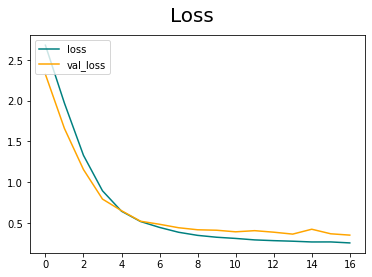

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

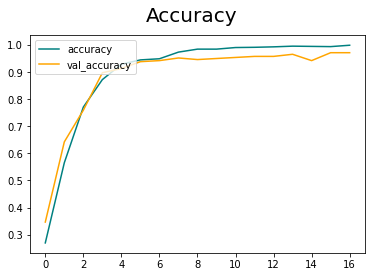

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Test on new collected image

In [ ]:
import cv2

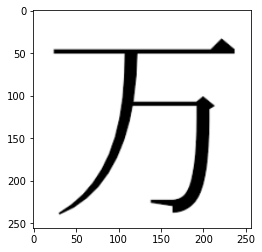

In [ ]:
#Testing on new data by resizing it with (256,256)

test_img=cv2.imread("drive/MyDrive/collected data/ten_4 (10 thousand)/Unknown-1.png")
plt.imshow(test_img)
rescaled_test_image = tf.image.resize(test_img, (256,256))
plt.imshow(rescaled_test_image.numpy().astype(int))

In [ ]:
yhat = model.predict(np.expand_dims(rescaled_test_image/255, 0))
np.argmax(yhat)

13

In [ ]:
model.save(os.path.join('drive/MyDrive/model','imageclassifier_vgg16_best.h5'))

In [ ]:
from tensorflow.keras import models
model = models.load_model("drive/MyDrive/model/imageclassifier_vgg16.h5")

In [ ]:
def preprocess(img_path):
    img=cv2.imread(img_path)
    rescaled_image = tf.image.resize(img, (256,256))
    processed_image = np.expand_dims(rescaled_image/255, 0)
    
    return processed_image


In [ ]:
test_image = preprocess("drive/MyDrive/seven.jpeg")
np.argmax(model.predict(test_image))

0

In [ ]:
model.make_predict_function()